In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency

pd.set_option("display.max_columns", None)

In [2]:
# Ler do dataframe original
"""df = pd.read_csv("../data/dados.csv", encoding="ISO-8859-1", sep=";", low_memory=False)
print(f'Linhas, Colunas: {df.shape} \n')
print(f'Informações: \n')
print(f'{df.info()}\n')"""


'df = pd.read_csv("../data/dados.csv", encoding="ISO-8859-1", sep=";", low_memory=False)\nprint(f\'Linhas, Colunas: {df.shape} \n\')\nprint(f\'Informações: \n\')\nprint(f\'{df.info()}\n\')'

In [3]:
#Overview do dataset
""" df.info() """

' df.info() '

In [4]:
#Carrega o dataset de taxas de rendimento
""" df_tx = pd.read_excel("../data/tx_rend.xlsx", skiprows = 8, nrows = 129307)
print(f'Linhas, Colunas: {df_tx.shape} \n')
print(f'Informações: \n')
print(f'{df_tx.info()}\n') """


' df_tx = pd.read_excel("../data/tx_rend.xlsx", skiprows = 8, nrows = 129307)\nprint(f\'Linhas, Colunas: {df_tx.shape} \n\')\nprint(f\'Informações: \n\')\nprint(f\'{df_tx.info()}\n\') '

In [5]:
#Dados os datatypes criados a partir dos dois datasets:
""" df.info()
df_tx.info() """

' df.info()\ndf_tx.info() '

In [6]:
# Criar a lista de entidade para cada uma das bases
""" lista_co_entidades_microdados = pd.Series(df['CO_ENTIDADE'].to_list())
lista_co_entidades_tx_rend = pd.Series(df_tx['CO_ENTIDADE'].to_list())
print(f'O dataset de microdados possui {len(lista_co_entidades_microdados)} códigos de entidade, enquanto o dataset de taxa de rendimentos possui {len(lista_co_entidades_tx_rend)} códigos.\n')

#Obtendo os códigos presentes em um dataset mas ausente em outro
codigos_diferentes = [cod for cod in lista_co_entidades_microdados.to_list() if cod not in lista_co_entidades_tx_rend.to_list()]
 """

" lista_co_entidades_microdados = pd.Series(df['CO_ENTIDADE'].to_list())\nlista_co_entidades_tx_rend = pd.Series(df_tx['CO_ENTIDADE'].to_list())\nprint(f'O dataset de microdados possui {len(lista_co_entidades_microdados)} códigos de entidade, enquanto o dataset de taxa de rendimentos possui {len(lista_co_entidades_tx_rend)} códigos.\n')\n\n#Obtendo os códigos presentes em um dataset mas ausente em outro\ncodigos_diferentes = [cod for cod in lista_co_entidades_microdados.to_list() if cod not in lista_co_entidades_tx_rend.to_list()]\n "

In [7]:
#Total de códigos diferentes
""" len(codigos_diferentes) """

' len(codigos_diferentes) '

In [8]:
#Criando um novo dataframe filtrando os microdados apenas para aqueles que não possuem CO_ENTIDADE que não 
#tem correspondente na base de taxa de rendimento
""" df_microdados = df.query('CO_ENTIDADE not in @codigos_diferentes').reset_index(drop=True)
df_microdados.info() """

" df_microdados = df.query('CO_ENTIDADE not in @codigos_diferentes').reset_index(drop=True)\ndf_microdados.info() "

In [9]:
#Seleciona as colunas relevantes a partir de seus índices
""" indices_col_tx = [5,45,57]
df_tx_filtrado = df_tx.iloc[:,indices_col_tx] """

' indices_col_tx = [5,45,57]\ndf_tx_filtrado = df_tx.iloc[:,indices_col_tx] '

In [10]:
""" #Renomeia as colunas do Dataframe alvo para ficarem com valores mais claros
df_tx_filtrado = df_tx_filtrado.rename(columns={"3_CAT_FUN" : "ABAND_FUND", "3_CAT_MED" : "ABAND_MED"})
df_tx_filtrado """

' #Renomeia as colunas do Dataframe alvo para ficarem com valores mais claros\ndf_tx_filtrado = df_tx_filtrado.rename(columns={"3_CAT_FUN" : "ABAND_FUND", "3_CAT_MED" : "ABAND_MED"})\ndf_tx_filtrado '

In [11]:
""" #Filtra as colunas selecionadas apenas do dataset de microdados:
indices_col_microdados = ['CO_ENTIDADE', 'IN_AGUA_POTAVEL', 'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_BANHEIRO', 'IN_BIBLIOTECA_SALA_LEITURA', 'IN_COZINHA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_PARQUE_INFANTIL', 'IN_QUADRA_ESPORTES',
                         'IN_REFEITORIO', 'IN_LABORATORIO_EDUC_PROF', 'IN_SALA_MULTIUSO', 'IN_SALA_REPOUSO_ALUNO', 'IN_ACESSIBILIDADE_INEXISTENTE', 'QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'IN_DESKTOP_ALUNO', 'IN_COMP_PORTATIL_ALUNO', 'IN_TABLET_ALUNO', 'IN_INTERNET', 'IN_INTERNET_APRENDIZAGEM',
                         'IN_INTERNET_COMUNIDADE', 'IN_PROF_BIBLIOTECARIO', 'IN_PROF_SAUDE', 'IN_ALIMENTACAO', 
                          'IN_ESPACO_ATIVIDADE', 'IN_FUND', 'IN_MED']
df_microdados_filtrado = df_microdados.loc[:,indices_col_microdados]
df_microdados_filtrado """

" #Filtra as colunas selecionadas apenas do dataset de microdados:\nindices_col_microdados = ['CO_ENTIDADE', 'IN_AGUA_POTAVEL', 'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_BANHEIRO', 'IN_BIBLIOTECA_SALA_LEITURA', 'IN_COZINHA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_PARQUE_INFANTIL', 'IN_QUADRA_ESPORTES',\n                         'IN_REFEITORIO', 'IN_LABORATORIO_EDUC_PROF', 'IN_SALA_MULTIUSO', 'IN_SALA_REPOUSO_ALUNO', 'IN_ACESSIBILIDADE_INEXISTENTE', 'QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'IN_DESKTOP_ALUNO', 'IN_COMP_PORTATIL_ALUNO', 'IN_TABLET_ALUNO', 'IN_INTERNET', 'IN_INTERNET_APRENDIZAGEM',\n                         'IN_INTERNET_COMUNIDADE', 'IN_PROF_BIBLIOTECARIO', 'IN_PROF_SAUDE', 'IN_ALIMENTACAO', \n                          'IN_ESPACO_ATIVIDADE', 'IN_FUND', 'IN_MED']\ndf_microdados_filtrado = df_microdados.loc[:,indices_col_microdados]\ndf_microdados_filtrado "

In [12]:
# Salva os dataframes em arquivos, para um checkpoint
""" df_tx_filtrado.to_pickle("../data/tx_aband.pk1")
df_microdados_filtrado.to_feather("../data/microdados.feather")
df_tx_filtrado.info()
df_microdados_filtrado.info() """

' df_tx_filtrado.to_pickle("../data/tx_aband.pk1")\ndf_microdados_filtrado.to_feather("../data/microdados.feather")\ndf_tx_filtrado.info()\ndf_microdados_filtrado.info() '

In [13]:
#Carrega do backup
df_tx_use = pd.read_pickle("../data/tx_aband.pk1")
df_mc_use = pd.read_feather("../data/microdados.feather")

df_microdados = df_mc_use.copy()
df_tx = df_tx_use.copy()
df_tx.info()
df_microdados.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129307 entries, 0 to 129306
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   CO_ENTIDADE  129307 non-null  int64 
 1   ABAND_FUND   129307 non-null  object
 2   ABAND_MED    129307 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129307 entries, 0 to 129306
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CO_ENTIDADE                    129307 non-null  int64  
 1   IN_AGUA_POTAVEL                129307 non-null  float64
 2   IN_ENERGIA_INEXISTENTE         129307 non-null  float64
 3   IN_ESGOTO_INEXISTENTE          129307 non-null  float64
 4   IN_BANHEIRO                    129307 non-null  float64
 5   IN_BIBLIOTECA_SALA_LEITURA     129307 non-null  float64
 6   IN_COZINHA                

In [14]:
#Produz um dataframe unindo a partir da coluna de CO_ENTIDADE
df_microdados = pd.merge(df_microdados, df_tx, on="CO_ENTIDADE")
df_microdados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129307 entries, 0 to 129306
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CO_ENTIDADE                    129307 non-null  int64  
 1   IN_AGUA_POTAVEL                129307 non-null  float64
 2   IN_ENERGIA_INEXISTENTE         129307 non-null  float64
 3   IN_ESGOTO_INEXISTENTE          129307 non-null  float64
 4   IN_BANHEIRO                    129307 non-null  float64
 5   IN_BIBLIOTECA_SALA_LEITURA     129307 non-null  float64
 6   IN_COZINHA                     129307 non-null  float64
 7   IN_LABORATORIO_CIENCIAS        129307 non-null  float64
 8   IN_LABORATORIO_INFORMATICA     129307 non-null  float64
 9   IN_PARQUE_INFANTIL             129307 non-null  float64
 10  IN_QUADRA_ESPORTES             129307 non-null  float64
 11  IN_REFEITORIO                  129307 non-null  float64
 12  IN_LABORATORIO_EDUC_PROF      

In [15]:
df_microdados

,CO_ENTIDADE,IN_AGUA_POTAVEL,IN_ENERGIA_INEXISTENTE,IN_ESGOTO_INEXISTENTE,IN_BANHEIRO,IN_BIBLIOTECA_SALA_LEITURA,IN_COZINHA,IN_LABORATORIO_CIENCIAS,IN_LABORATORIO_INFORMATICA,IN_PARQUE_INFANTIL,IN_QUADRA_ESPORTES,IN_REFEITORIO,IN_LABORATORIO_EDUC_PROF,IN_SALA_MULTIUSO,IN_SALA_REPOUSO_ALUNO,IN_ACESSIBILIDADE_INEXISTENTE,QT_SALAS_UTILIZADAS,QT_SALAS_UTILIZA_CLIMATIZADAS,IN_DESKTOP_ALUNO,IN_COMP_PORTATIL_ALUNO,IN_TABLET_ALUNO,IN_INTERNET,IN_INTERNET_APRENDIZAGEM,IN_INTERNET_COMUNIDADE,IN_PROF_BIBLIOTECARIO,IN_PROF_SAUDE,IN_ALIMENTACAO,IN_ESPACO_ATIVIDADE,IN_FUND,IN_MED,ABAND_FUND,ABAND_MED
0,11022558,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,--
1,11024291,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,--
2,11024372,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,9.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,--
3,11024666,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0,--
4,11024682,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,36.0,12.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.7,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129302,53084020,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,12.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,--
129303,53084039,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,50.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0,--
129304,53084055,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0
129305,53085000,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,20.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,--


In [16]:
#Dividir as bases que tem fund e as que não tem IN_FUND e IN_MED
df_microdados_fund = df_microdados.query('IN_FUND == 1').reset_index(drop=True)
df_microdados_med = df_microdados.query('IN_MED == 1').reset_index(drop=True)

#Remover as colunas de indicador já que a divisão já foi feita
df_microdados_fund = df_microdados_fund.drop(['IN_FUND', 'IN_MED', 'ABAND_MED' ], axis =1)
df_microdados_med = df_microdados_med.drop(['IN_FUND', 'IN_MED', 'ABAND_FUND' ], axis =1)

df_microdados_fund['ABAND_FUND'] = df_microdados_fund['ABAND_FUND'].replace('--', 0)
df_microdados_med['ABAND_MED'] = df_microdados_med['ABAND_MED'].replace('--', 0)
df_microdados_fund['ABAND_FUND'] = df_microdados_fund['ABAND_FUND'].astype('float')
df_microdados_med['ABAND_MED'] = df_microdados_med['ABAND_MED'].astype('float')

In [17]:
df_microdados_fund.head()

,CO_ENTIDADE,IN_AGUA_POTAVEL,IN_ENERGIA_INEXISTENTE,IN_ESGOTO_INEXISTENTE,IN_BANHEIRO,IN_BIBLIOTECA_SALA_LEITURA,IN_COZINHA,IN_LABORATORIO_CIENCIAS,IN_LABORATORIO_INFORMATICA,IN_PARQUE_INFANTIL,IN_QUADRA_ESPORTES,IN_REFEITORIO,IN_LABORATORIO_EDUC_PROF,IN_SALA_MULTIUSO,IN_SALA_REPOUSO_ALUNO,IN_ACESSIBILIDADE_INEXISTENTE,QT_SALAS_UTILIZADAS,QT_SALAS_UTILIZA_CLIMATIZADAS,IN_DESKTOP_ALUNO,IN_COMP_PORTATIL_ALUNO,IN_TABLET_ALUNO,IN_INTERNET,IN_INTERNET_APRENDIZAGEM,IN_INTERNET_COMUNIDADE,IN_PROF_BIBLIOTECARIO,IN_PROF_SAUDE,IN_ALIMENTACAO,IN_ESPACO_ATIVIDADE,ABAND_FUND
0,11022558,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,11024291,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,11024372,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,9.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,11024666,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,11024682,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,36.0,12.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.7


In [18]:
df_microdados_med.info(max_cols =1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29384 entries, 0 to 29383
Columns: 29 entries, CO_ENTIDADE to ABAND_MED
dtypes: float64(28), int64(1)
memory usage: 6.5 MB


In [19]:
#Estatísticas básicas das variáveis instituições fundamental
df_microdados_fund.describe(include = 'all')

,CO_ENTIDADE,IN_AGUA_POTAVEL,IN_ENERGIA_INEXISTENTE,IN_ESGOTO_INEXISTENTE,IN_BANHEIRO,IN_BIBLIOTECA_SALA_LEITURA,IN_COZINHA,IN_LABORATORIO_CIENCIAS,IN_LABORATORIO_INFORMATICA,IN_PARQUE_INFANTIL,IN_QUADRA_ESPORTES,IN_REFEITORIO,IN_LABORATORIO_EDUC_PROF,IN_SALA_MULTIUSO,IN_SALA_REPOUSO_ALUNO,IN_ACESSIBILIDADE_INEXISTENTE,QT_SALAS_UTILIZADAS,QT_SALAS_UTILIZA_CLIMATIZADAS,IN_DESKTOP_ALUNO,IN_COMP_PORTATIL_ALUNO,IN_TABLET_ALUNO,IN_INTERNET,IN_INTERNET_APRENDIZAGEM,IN_INTERNET_COMUNIDADE,IN_PROF_BIBLIOTECARIO,IN_PROF_SAUDE,IN_ALIMENTACAO,IN_ESPACO_ATIVIDADE,ABAND_FUND
count,1.208560e+05,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.00000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000,120856.000000
mean,2.948470e+07,0.946689,0.024699,0.053502,0.964255,0.573426,0.918349,0.134971,0.361546,0.27153,0.457727,0.416065,0.002540,0.082379,0.017153,0.336069,8.934534,3.143692,0.509697,0.387072,0.146000,0.846238,0.580219,0.046675,0.253955,0.033188,0.831858,0.871235,1.271425
std,9.957755e+06,0.224655,0.155206,0.225033,0.185655,0.494581,0.273833,0.341694,0.480450,0.44475,0.498212,0.492907,0.050337,0.274942,0.129841,0.472365,7.502730,6.179498,0.499908,0.487082,0.353108,0.360721,0.493525,0.210943,0.435274,0.179129,0.373994,1.890061,3.937556
min,1.100006e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.213393e+07,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,2.932659e+07,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.513424e+07,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,12.000000,5.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.800000
max,5.308601e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,312.000000,117.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,100.000000


In [20]:
#Estatísticas básicas das variáveis instituições med
df_microdados_med.describe(include = 'all')

,CO_ENTIDADE,IN_AGUA_POTAVEL,IN_ENERGIA_INEXISTENTE,IN_ESGOTO_INEXISTENTE,IN_BANHEIRO,IN_BIBLIOTECA_SALA_LEITURA,IN_COZINHA,IN_LABORATORIO_CIENCIAS,IN_LABORATORIO_INFORMATICA,IN_PARQUE_INFANTIL,IN_QUADRA_ESPORTES,IN_REFEITORIO,IN_LABORATORIO_EDUC_PROF,IN_SALA_MULTIUSO,IN_SALA_REPOUSO_ALUNO,IN_ACESSIBILIDADE_INEXISTENTE,QT_SALAS_UTILIZADAS,QT_SALAS_UTILIZA_CLIMATIZADAS,IN_DESKTOP_ALUNO,IN_COMP_PORTATIL_ALUNO,IN_TABLET_ALUNO,IN_INTERNET,IN_INTERNET_APRENDIZAGEM,IN_INTERNET_COMUNIDADE,IN_PROF_BIBLIOTECARIO,IN_PROF_SAUDE,IN_ALIMENTACAO,IN_ESPACO_ATIVIDADE,ABAND_MED
count,2.938400e+04,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.00000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000,29384.000000
mean,3.267633e+07,0.975871,0.003778,0.012013,0.986796,0.880377,0.907433,0.483222,0.697080,0.213960,0.772053,0.541111,0.025150,0.150898,0.026545,0.242275,14.56786,6.101960,0.799415,0.564695,0.223115,0.967465,0.800538,0.080996,0.491152,0.083106,0.725633,0.723319,4.535849
std,9.545575e+06,0.153452,0.061347,0.108947,0.114151,0.324526,0.289830,0.499727,0.459529,0.410106,0.419515,0.498316,0.156582,0.357956,0.160752,0.428467,10.13520,9.615673,0.400445,0.495805,0.416342,0.177418,0.399603,0.272834,0.499930,0.276048,0.446202,1.662303,7.466137
min,1.100006e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.616898e+07,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.00000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.308866e+07,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.00000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.100000
75%,3.592001e+07,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,17.00000,10.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,6.600000
max,5.308601e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,262.00000,150.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,100.000000


In [21]:
#Analise descritiva para a variável alvo fundamental
df_microdados_fund['ABAND_FUND'].describe()

count    120856.000000
mean          1.271425
std           3.937556
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         100.000000
Name: ABAND_FUND, dtype: float64

In [22]:
#Analise descritiva para a variável alvo médio
df_microdados_med['ABAND_MED'].describe()

count    29384.000000
mean         4.535849
std          7.466137
min          0.000000
25%          0.000000
50%          1.100000
75%          6.600000
max        100.000000
Name: ABAND_MED, dtype: float64

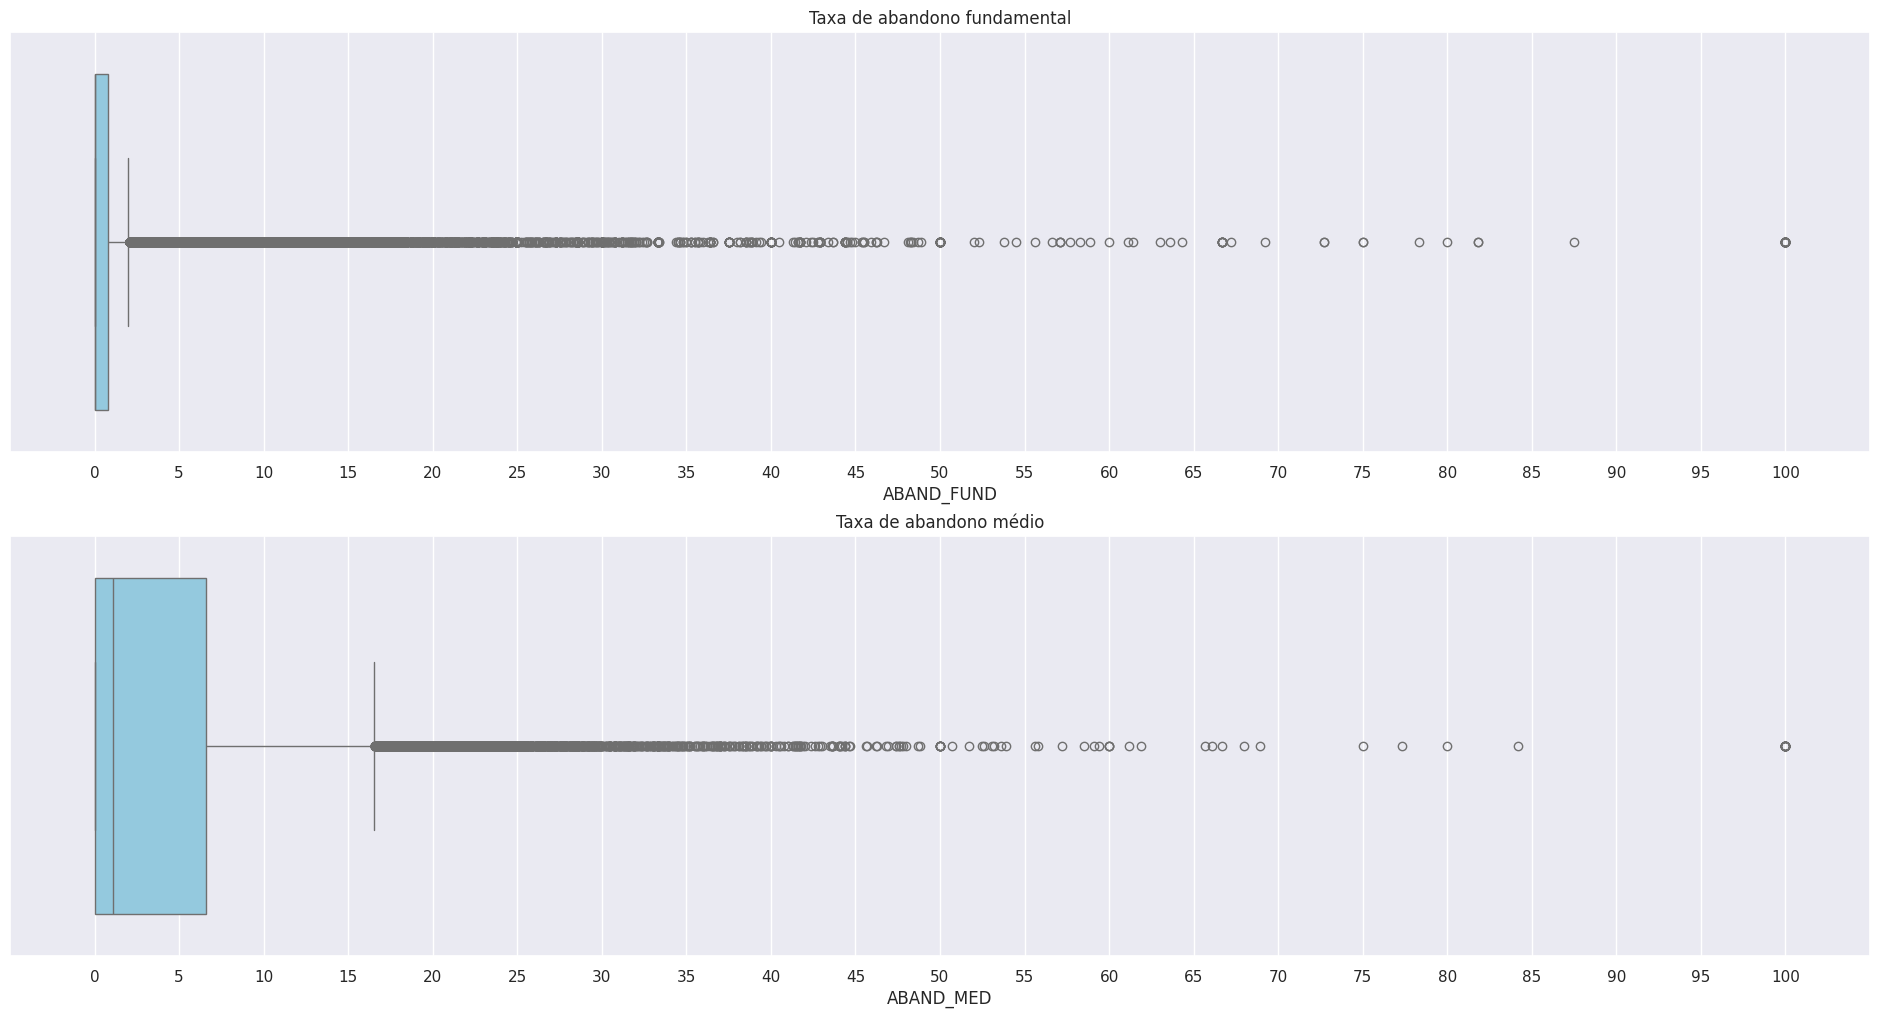

In [23]:
sns.set_theme()
plt.figure(figsize=(24,12))
plt.subplot(2,1,1)
sns.boxplot(data=df_microdados_fund, x='ABAND_FUND', color='skyblue')
plt.title("Taxa de abandono fundamental")
plt.xticks(range(0,101,5))

plt.subplot(2,1,2)
sns.boxplot(data=df_microdados_med, x='ABAND_MED', color='skyblue')
plt.title("Taxa de abandono médio")
plt.xticks(range(0,101,5))

plt.show()


In [24]:
# Lista para armazenar as colunas relevantes
relevant_columns_fund = []
#Itera sobre as colunas do dataframe para criar uma tabela de contigência entre cada coluna e a variável alvo
for column in df_microdados_fund.columns:
    contigency_table = pd.crosstab(df_microdados_fund[column],df_microdados_fund['ABAND_FUND'])
    _, p, _, _ = chi2_contingency(contigency_table)
    
    if p < 0.05:
        relevant_columns_fund.append(column)
    
print(relevant_columns_fund)
    

['IN_AGUA_POTAVEL', 'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_BANHEIRO', 'IN_BIBLIOTECA_SALA_LEITURA', 'IN_COZINHA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_PARQUE_INFANTIL', 'IN_QUADRA_ESPORTES', 'IN_REFEITORIO', 'IN_SALA_MULTIUSO', 'IN_ACESSIBILIDADE_INEXISTENTE', 'IN_DESKTOP_ALUNO', 'IN_COMP_PORTATIL_ALUNO', 'IN_TABLET_ALUNO', 'IN_INTERNET', 'IN_INTERNET_APRENDIZAGEM', 'IN_PROF_BIBLIOTECARIO', 'IN_PROF_SAUDE', 'IN_ALIMENTACAO', 'IN_ESPACO_ATIVIDADE', 'ABAND_FUND']


In [25]:
# Lista para armazenar as colunas relevantes
relevant_columns_med = []
#Itera sobre as colunas do dataframe para criar uma tabela de contigência entre cada coluna e a variável alvo
for column in df_microdados_med.columns:
    contigency_table = pd.crosstab(df_microdados_med[column],df_microdados_med['ABAND_MED'])
    _, p, _, _ = chi2_contingency(contigency_table)
    
    if p < 0.05:
        relevant_columns_med.append(column)
    
print(relevant_columns_med)

['IN_AGUA_POTAVEL', 'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_BANHEIRO', 'IN_BIBLIOTECA_SALA_LEITURA', 'IN_COZINHA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_PARQUE_INFANTIL', 'IN_QUADRA_ESPORTES', 'IN_REFEITORIO', 'IN_SALA_MULTIUSO', 'IN_ACESSIBILIDADE_INEXISTENTE', 'QT_SALAS_UTILIZADAS', 'IN_DESKTOP_ALUNO', 'IN_COMP_PORTATIL_ALUNO', 'IN_TABLET_ALUNO', 'IN_INTERNET', 'IN_INTERNET_APRENDIZAGEM', 'IN_PROF_BIBLIOTECARIO', 'IN_PROF_SAUDE', 'IN_ALIMENTACAO', 'IN_ESPACO_ATIVIDADE', 'ABAND_MED']


In [26]:
print (f'Colunas em comum: {[i for i in relevant_columns_fund if i in relevant_columns_med]}')

print (f'Colunas em distinto: {[i for i in df_microdados_med if i not in relevant_columns_med]}')

Colunas em comum: ['IN_AGUA_POTAVEL', 'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_BANHEIRO', 'IN_BIBLIOTECA_SALA_LEITURA', 'IN_COZINHA', 'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_PARQUE_INFANTIL', 'IN_QUADRA_ESPORTES', 'IN_REFEITORIO', 'IN_SALA_MULTIUSO', 'IN_ACESSIBILIDADE_INEXISTENTE', 'IN_DESKTOP_ALUNO', 'IN_COMP_PORTATIL_ALUNO', 'IN_TABLET_ALUNO', 'IN_INTERNET', 'IN_INTERNET_APRENDIZAGEM', 'IN_PROF_BIBLIOTECARIO', 'IN_PROF_SAUDE', 'IN_ALIMENTACAO', 'IN_ESPACO_ATIVIDADE']
Colunas em distinto: ['CO_ENTIDADE', 'IN_LABORATORIO_EDUC_PROF', 'IN_SALA_REPOUSO_ALUNO', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'IN_INTERNET_COMUNIDADE']
